# Drug Reviews Notebook

#### Ryan Butler: https://github.com/ryangbutler

The purpose of this notebook is to create reports based on sentiment analysis and summarization of the product reviews. This includes:
* Application of well-known sentiment analysis tools
* Visualizations/Descriptive Statistics

Download the datasets from this Kaggle link: https://www.kaggle.com/datasets/jessicali9530/kuc-hackathon-winter-2018 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

plt.style.use('ggplot')

We have a test and train set, but let's combine them for better descriptive stats

In [2]:
train = pd.read_csv('drugsComTrain_raw.csv')
test = pd.read_csv('drugsComTest_raw.csv')

In [3]:
train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [4]:
test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


We have the same columns between these datasets, so all clear to concat

In [58]:
total_data = pd.concat([train,test])
total_data

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
...,...,...,...,...,...,...,...
53761,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10,13-Sep-14,43
53762,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9,8-Oct-16,11
53763,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8,15-Nov-10,7
53764,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1,28-Nov-11,20


# EDA

In [6]:
total_data.isna().sum()

uniqueID          0
drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
dtype: int64

In [7]:
total_data['condition'].fillna('No Condition Specified', inplace=True)

In [8]:
total_data.isna().sum()

uniqueID       0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

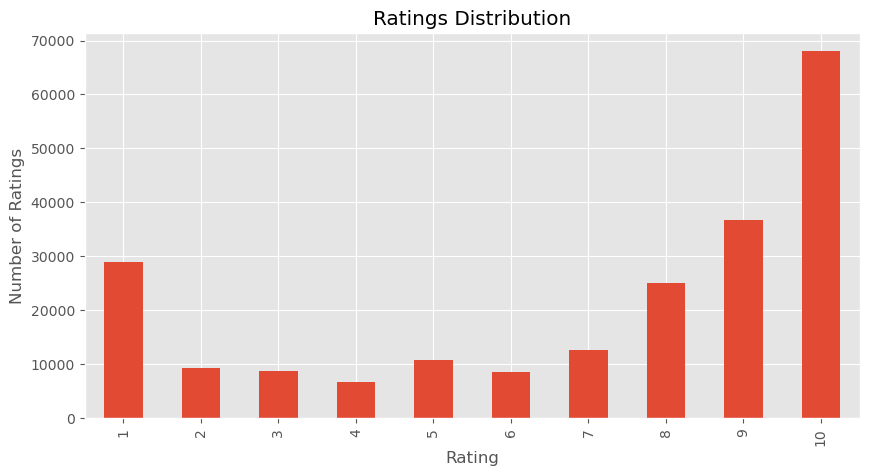

In [9]:
ax = total_data['rating'].value_counts().sort_index().plot(kind='bar', title='Ratings Distribution', figsize=(10,5))
ax.set_xlabel('Rating')
ax.set_ylabel('Number of Ratings')
plt.show()

We should expect a lot more positive reviews than negative reviews based on the above distribution

# Sentiment Analysis

To evaluate the accuracy of the models used, we should create a small metric to see if the reviews generally fall into what we would expect based on the rating.  We will use the ratings scale as a metric for what category we would estimate each review to fall into. <br>
If the rating is high, we would expect the review to also be positive and same goes for low ratings being negative etc. <br>
Since it will take an absurd amount of time to run these models on the entire dataset, we are going to select the first 5000 ratings and assess their error rates.  Then select the best model and run that.

* Negative == 1-4
* Neutral == 5-6
* Positive == 7-10

Depending on which sentiment tool is the most accurate, we will move forward with utilizing it

### Create a new column which contains these preliminary ratings

In [10]:
prelim_ratings = []

for rating in total_data['rating']:
    if rating in range(1,5):
        prelim_ratings.append('Negative')
    elif rating in range(5,7):
        prelim_ratings.append('Neutral')
    else:
        prelim_ratings.append('Positive')

In [11]:
# Double checking we get same length
print(len(prelim_ratings), len(total_data)) 

215063 215063


In [12]:
total_data['estimated sentiment'] = prelim_ratings
total_data

,uniqueID,drugName,condition,review,rating,date,usefulCount,estimated sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,Positive
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,Positive
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,Neutral
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,Positive
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,Positive
...,...,...,...,...,...,...,...,...
53761,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10,13-Sep-14,43,Positive
53762,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9,8-Oct-16,11,Positive
53763,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8,15-Nov-10,7,Positive
53764,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1,28-Nov-11,20,Negative


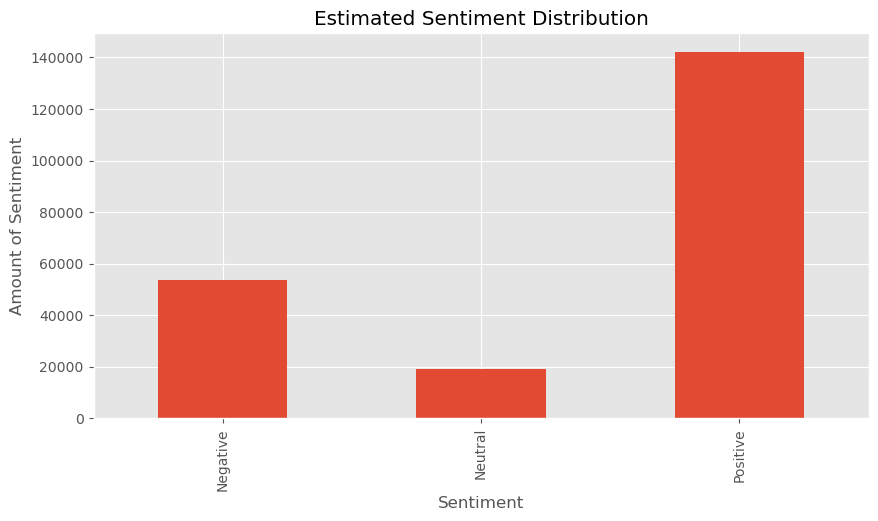

In [13]:
ax = total_data['estimated sentiment'].value_counts().sort_index().plot(kind='bar', title='Estimated Sentiment Distribution', figsize=(10,5))
ax.set_xlabel('Sentiment')
ax.set_ylabel('Amount of Sentiment')
plt.show()

# Sentiment Analysis Models

## NLTK VADER

In [14]:
# nltk.download('vader_lexicon')

In [15]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [16]:
sia

In [17]:
res = {}
for i, row in tqdm(total_data[:5000].iterrows(), total=5000):
    text = row['review']
    myid = row['uniqueID']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [18]:
# res

In [19]:
# Defining compound score >= 0.05 as Positive
## Defining compound score <= -0.05 as Negative
## Anything else between is Neutral

sentiment_vader = {'uniqueID':[], 'vaderSentiment':[]}
for i,v in res.items():
    if res[i]['compound'] >= 0.05:
        sentiment =  "Positive"
    elif res[i]['compound'] <= -0.05:
        sentiment =  "Negative"
    else:
        sentiment = "Neutral"
        
    sentiment_vader['uniqueID'].append(i)
    sentiment_vader['vaderSentiment'].append(sentiment)
# sentiment_vader

In [20]:
sentiment_vader_df = pd.DataFrame.from_dict(sentiment_vader)
sentiment_vader_df

,uniqueID,vaderSentiment
0,206461,Negative
1,95260,Positive
2,92703,Positive
3,138000,Positive
4,35696,Positive
...,...,...
4995,45298,Positive
4996,190504,Negative
4997,183187,Negative
4998,114593,Negative


In [21]:
total_data2 = pd.merge(total_data, sentiment_vader_df, on='uniqueID')
total_data2

,uniqueID,drugName,condition,review,rating,date,usefulCount,estimated sentiment,vaderSentiment
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,Positive,Negative
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,Positive,Positive
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,Neutral,Positive
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,Positive,Positive
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,Positive,Positive
...,...,...,...,...,...,...,...,...,...
4995,45298,Fluoxetine,Hot Flashes,"""I was having hot flashes every night from bei...",10,25-Jan-16,26,Positive,Positive
4996,190504,Butorphanol,Pain,"""I was initially prescribed this for frequent ...",9,21-Feb-15,1,Positive,Negative
4997,183187,Cymbalta,Anxiety,"""I have suffered from anxiety problems my whol...",8,13-Jul-13,81,Positive,Negative
4998,114593,Codeine / promethazine,Cough,"""This is the only thing will stop my cough. I ...",10,16-Oct-15,21,Positive,Negative


#### Get the VADER 'error' rate

In [22]:
er_dict = {}
error_df = total_data2[total_data2['estimated sentiment'] != total_data2['vaderSentiment']]
vader_error = (len(error_df)/len(total_data2))*100
er_dict['VADER'] = vader_error
print(f'VADER Error rate is {vader_error}%')

VADER Error rate is 45.76%


## RoBERTa Pretrained Model

In [23]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [24]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [25]:
# example = total_data['review'][1]
# encoded_text = tokenizer(example, return_tensors='pt')
# encoded_text

In [26]:
# output = model(**encoded_text)
# scores = output[0][0].detach().numpy()
# scores = softmax(scores)
# scores_dict = {'roberta_neg':scores[0],
#                'roberta_neu':scores[1],
#                'roberta_pos':scores[1]
#               }
# print(scores_dict)

In [27]:
# Utilizing a function for RoBERTa so we can iterate through each review
def polarity_scores_roberta(rating):
    encoded_text = tokenizer(rating, return_tensors='pt', truncation=True, max_length=512)
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {'Negative':scores[0],
                   'Neutral':scores[1],
                   'Positive':scores[2]
                  }
    return scores_dict

In [28]:
# These scores should be the same as previous example
## If they are the same, function is working as expected
# polarity_scores_roberta(example)

In [29]:
res = {}
for i, row in tqdm(total_data[:5000].iterrows(), total=5000):
    text = row['review']
    myid = row['uniqueID']
    roberta_result = polarity_scores_roberta(text)
    res[myid] = roberta_result

  0%|          | 0/5000 [00:00<?, ?it/s]

In [30]:
# res

In [31]:
# Defining compound score >= 0.05 as Positive
## Defining compound score <= -0.05 as Negative
## Anything else between is Neutral

sentiment_roberta = {'uniqueID':[], 'robertaSentiment':[]}
for i,v in res.items():
    sent_dict = v
    max_sent = max(sent_dict, key=sent_dict.get)
    sentiment_roberta['uniqueID'].append(i)
    sentiment_roberta['robertaSentiment'].append(max_sent)
# sentiment_roberta

In [32]:
sentiment_roberta_df = pd.DataFrame.from_dict(sentiment_roberta)
sentiment_roberta_df

,uniqueID,robertaSentiment
0,206461,Neutral
1,95260,Positive
2,92703,Negative
3,138000,Positive
4,35696,Positive
...,...,...
4995,45298,Positive
4996,190504,Neutral
4997,183187,Positive
4998,114593,Negative


In [33]:
total_data2 = pd.merge(total_data2, sentiment_roberta_df, on='uniqueID')
total_data2

,uniqueID,drugName,condition,review,rating,date,usefulCount,estimated sentiment,vaderSentiment,robertaSentiment
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,Positive,Negative,Neutral
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,Positive,Positive,Positive
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,Neutral,Positive,Negative
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,Positive,Positive,Positive
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,Positive,Positive,Positive
...,...,...,...,...,...,...,...,...,...,...
4995,45298,Fluoxetine,Hot Flashes,"""I was having hot flashes every night from bei...",10,25-Jan-16,26,Positive,Positive,Positive
4996,190504,Butorphanol,Pain,"""I was initially prescribed this for frequent ...",9,21-Feb-15,1,Positive,Negative,Neutral
4997,183187,Cymbalta,Anxiety,"""I have suffered from anxiety problems my whol...",8,13-Jul-13,81,Positive,Negative,Positive
4998,114593,Codeine / promethazine,Cough,"""This is the only thing will stop my cough. I ...",10,16-Oct-15,21,Positive,Negative,Negative


### Get RoBERTa 'Error' Rate

In [34]:
error_df = total_data2[total_data2['estimated sentiment'] != total_data2['robertaSentiment']]
roberta_error = (len(error_df)/len(total_data2))*100
er_dict['RoBERTa'] = roberta_error
print(f'RoBERTa Error rate is {roberta_error}%')

RoBERTa Error rate is 35.620000000000005%


## spaCy

In [1]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

In [36]:
nlp = spacy.load('en_core_web_sm')
example = 'This is really the worst, bad, terrible, fuck, cunt.'
nlp.add_pipe("spacytextblob")
doc = nlp(text)

In [37]:
print(doc._.blob.polarity)

0.3833333333333333


In [38]:
print(doc._.blob.sentiment_assessments.assessments)

[(['old'], 0.1, 0.2, None), (['strong'], 0.4333333333333333, 0.7333333333333333, None), (['better'], 0.5, 0.5, None), (['love'], 0.5, 0.6, None)]


In [39]:
res = {}
for i, row in tqdm(total_data[:5000].iterrows(), total=5000):
    text = row['review']
    myid = row['uniqueID']
    spacy_doc = nlp(text)
    spacy_result = spacy_doc._.blob.polarity

    if spacy_result <= -0.05:
        sentiment = "Negative"
    elif spacy_result >= 0.05:
        sentiment = "Positive"
    else:
        sentiment = "Neutral"
        
    res[myid] = sentiment

  0%|          | 0/5000 [00:00<?, ?it/s]

In [40]:
sentiment_spacy = {'uniqueID':[], 'spacySentiment':[]}
for i,v in res.items():
    sentiment_spacy['uniqueID'].append(i)
    sentiment_spacy['spacySentiment'].append(v)

In [41]:
sentiment_spacy_df = pd.DataFrame.from_dict(sentiment_spacy)
sentiment_spacy_df

,uniqueID,spacySentiment
0,206461,Neutral
1,95260,Positive
2,92703,Positive
3,138000,Positive
4,35696,Positive
...,...,...
4995,45298,Positive
4996,190504,Neutral
4997,183187,Positive
4998,114593,Neutral


In [42]:
total_data2 = pd.merge(total_data2,sentiment_spacy_df, on='uniqueID')
total_data2

,uniqueID,drugName,condition,review,rating,date,usefulCount,estimated sentiment,vaderSentiment,robertaSentiment,spacySentiment
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,Positive,Negative,Neutral,Neutral
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,Positive,Positive,Positive,Positive
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,Neutral,Positive,Negative,Positive
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,Positive,Positive,Positive,Positive
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,Positive,Positive,Positive,Positive
...,...,...,...,...,...,...,...,...,...,...,...
4995,45298,Fluoxetine,Hot Flashes,"""I was having hot flashes every night from bei...",10,25-Jan-16,26,Positive,Positive,Positive,Positive
4996,190504,Butorphanol,Pain,"""I was initially prescribed this for frequent ...",9,21-Feb-15,1,Positive,Negative,Neutral,Neutral
4997,183187,Cymbalta,Anxiety,"""I have suffered from anxiety problems my whol...",8,13-Jul-13,81,Positive,Negative,Positive,Positive
4998,114593,Codeine / promethazine,Cough,"""This is the only thing will stop my cough. I ...",10,16-Oct-15,21,Positive,Negative,Negative,Neutral


### Get spaCy 'error' rate

In [43]:
error_df = total_data2[total_data2['estimated sentiment'] != total_data2['spacySentiment']]
spacy_error = (len(error_df)/len(total_data2))*100
er_dict['spacy'] = spacy_error
print(f'spaCy Error rate is {spacy_error}%')

spaCy Error rate is 46.44%


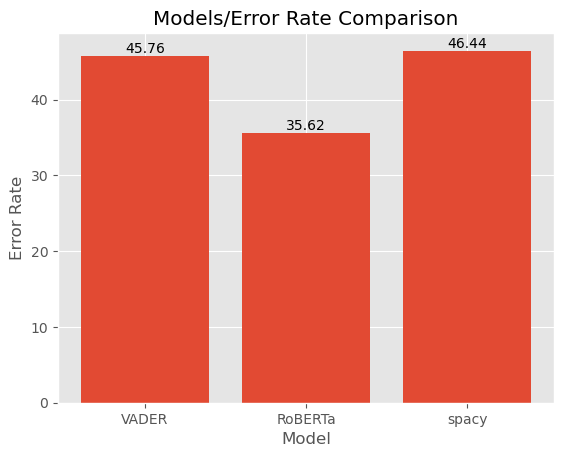

In [44]:
# function to add value labels
x = er_dict.keys()
y = er_dict.values()
barplot = plt.bar(x,y)
plt.bar_label(barplot)
plt.xlabel('Model')
plt.ylabel('Error Rate')
plt.title("Models/Error Rate Comparison")
plt.show()

#### From the above, we can see that the RoBERTA Model is performing the best with the lowest error rate.  So if we had to run the full dataset of reviews, we would select this to run (here is the code below to run this should we choose)

!!! WARNING !!! THE BELOW CODE WILL TAKE APPROXIMATELY 6-12 HOURS DEPENDING ON YOUR MACHINE

In [45]:
res = {}
for i, row in tqdm(total_data.iterrows(), total=len(total_data)):
    text = row['review']
    myid = row['uniqueID']
    roberta_result = polarity_scores_roberta(text)
    res[myid] = roberta_result

sentiment_roberta = {'uniqueID':[], 'robertaSentiment':[]}
for i,v in res.items():
    sent_dict = v
    max_sent = max(sent_dict, key=sent_dict.get)
    sentiment_roberta['uniqueID'].append(i)
    sentiment_roberta['robertaSentiment'].append(max_sent)

sentiment_roberta_df = pd.DataFrame.from_dict(sentiment_roberta)
sentiment_roberta_df

  0%|          | 0/215063 [00:00<?, ?it/s]

,uniqueID,robertaSentiment
0,206461,Neutral
1,95260,Positive
2,92703,Negative
3,138000,Positive
4,35696,Positive
...,...,...
215058,159999,Neutral
215059,140714,Positive
215060,130945,Neutral
215061,47656,Negative


In [59]:
total_data = pd.merge(total_data, sentiment_roberta_df, on='uniqueID')

# Descriptive Statistics

In [60]:
total_data

,uniqueID,drugName,condition,review,rating,date,usefulCount,robertaSentiment
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,Neutral
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,Positive
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,Negative
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,Positive
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,Positive
...,...,...,...,...,...,...,...,...
215058,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10,13-Sep-14,43,Neutral
215059,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9,8-Oct-16,11,Positive
215060,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8,15-Nov-10,7,Neutral
215061,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1,28-Nov-11,20,Negative


Save the data so we don't have have to rerun the above code

In [61]:
total_data.to_csv('total_data_roberta.csv', index=False)

In [62]:
max_ratings = total_data['drugName'].value_counts().max()
max_ratings 

4930

In [63]:
min_ratings = total_data['drugName'].value_counts().min()
min_ratings

1

In [64]:
mean_ratings = (max_ratings+min_ratings)/2
mean_ratings

2465.5

### Which drug had the highest average rating?

We also need to account for drugs which may have had only 1 rating, which biases the results. These could be dropped or we could filter those below a certain threshold

Let's get 1000 reviews as our threshold

In [65]:
n_ratings = dict(total_data['drugName'].value_counts())
drugs = []

for k,v in n_ratings.items():
    if v >= 1000:
        drugs.append(k)
drugs

['Levonorgestrel',
 'Etonogestrel',
 'Ethinyl estradiol / norethindrone',
 'Nexplanon',
 'Ethinyl estradiol / norgestimate',
 'Ethinyl estradiol / levonorgestrel',
 'Phentermine',
 'Sertraline',
 'Escitalopram',
 'Mirena',
 'Implanon',
 'Gabapentin',
 'Bupropion',
 'Miconazole',
 'Venlafaxine',
 'Medroxyprogesterone',
 'Citalopram',
 'Duloxetine',
 'Lexapro',
 'Bupropion / naltrexone',
 'Contrave',
 'Metronidazole',
 'Drospirenone / ethinyl estradiol',
 'Depo-Provera',
 'Clonazepam',
 'Cymbalta',
 'Tramadol',
 'Varenicline',
 'Zoloft',
 'Quetiapine',
 'Skyla',
 'Liraglutide',
 'Fluoxetine']

In [66]:
total_data_drugs = total_data[total_data['drugName'].isin(drugs)]
total_data_drugs

,uniqueID,drugName,condition,review,rating,date,usefulCount,robertaSentiment
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,7-Mar-17,5,Neutral
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1,Negative
14,98494,Nexplanon,Birth Control,"""Started Nexplanon 2 months ago because I have...",3,7-Aug-14,10,Negative
15,81890,Liraglutide,Obesity,"""I have been taking Saxenda since July 2016. ...",9,19-Jan-17,20,Positive
22,227020,Etonogestrel,Birth Control,"""Nexplanon does its job. I can have worry free...",9,11-Aug-14,11,Positive
...,...,...,...,...,...,...,...,...
215029,28754,Lexapro,Depression,"""I&#039;m a 19 year old girl and I&#039;ve bee...",7,20-Aug-10,26,Negative
215038,131040,Levonorgestrel,Birth Control,"""I first would like to thank all of you that p...",3,20-Jan-10,140,Negative
215044,199982,Varenicline,Smoking Cessation,"""Horrible! I have been a smoker for 14 years. ...",1,27-Jan-16,12,Negative
215059,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9,8-Oct-16,11,Positive


In [82]:
total_data_drugs.groupby('drugName', as_index=False)['rating'].mean().sort_values(by='rating', ascending=False)[:10]

,drugName,rating
30,Varenicline,8.799083
25,Phentermine,8.776978
3,Clonazepam,8.520070
19,Liraglutide,7.953967
18,Lexapro,7.912000
9,Escitalopram,7.829422
14,Fluoxetine,7.651830
2,Citalopram,7.597859
32,Zoloft,7.520258
0,Bupropion,7.478451


### Which drugs had the most positive reviews?

In [75]:
total_data_positive = total_data_drugs.groupby('drugName', as_index=False)['robertaSentiment'].value_counts()
total_data_positive = total_data_positive[total_data_positive['robertaSentiment'] == 'Positive']
total_data_positive.sort_values(by='count', ascending=False, inplace=True)
total_data_positive[:10]

,drugName,robertaSentiment,count
52,Levonorgestrel,Positive,1717
40,Etonogestrel,Positive,1507
34,Ethinyl estradiol / norethindrone,Positive,1404
75,Phentermine,Positive,1398
37,Ethinyl estradiol / norgestimate,Positive,1044
31,Ethinyl estradiol / levonorgestrel,Positive,971
81,Sertraline,Positive,963
27,Escitalopram,Positive,963
73,Nexplanon,Positive,901
0,Bupropion,Positive,715


Of the drugs which had 1000+ reviews, the above were the top ten drugs with the most positive reviews based on sentiment analysis

### Which drugs had the most negative reviews?

In [78]:
total_data_negative = total_data_drugs.groupby('drugName', as_index=False)['robertaSentiment'].value_counts()
total_data_negative = total_data_negative[total_data_negative['robertaSentiment'] == 'Negative']
total_data_negative.sort_values(by='count', ascending=False, inplace=True)
total_data_negative[:10]

,drugName,robertaSentiment,count
39,Etonogestrel,Negative,2329
51,Levonorgestrel,Negative,2171
33,Ethinyl estradiol / norethindrone,Negative,1886
72,Nexplanon,Negative,1628
36,Ethinyl estradiol / norgestimate,Negative,1392
30,Ethinyl estradiol / levonorgestrel,Negative,1200
66,Miconazole,Negative,1062
60,Medroxyprogesterone,Negative,822
63,Metronidazole,Negative,775
18,Depo-Provera,Negative,740


Of the drugs which had 1000+ reviews, the above were the top ten drugs with the most negative reviews based on sentiment analysis. Interestingly, Etonogestrel is in both lists, but has more negative reviews than positive. 

### Which condition had the most positive reviews for their treatment?

In [79]:
total_data_condition = total_data.groupby('condition', as_index=False)['robertaSentiment'].value_counts()
total_data_condition = total_data_condition[total_data_condition['robertaSentiment'] == 'Positive']
total_data_condition.sort_values(by='count', ascending=False, inplace=True)
total_data_condition[:10]

,condition,robertaSentiment,count
380,Birth Control,Positive,14532
617,Depression,Positive,6155
274,Anxiety,Positive,4152
166,Acne,Positive,3974
1424,Pain,Positive,3957
2010,Weight Loss,Positive,2965
376,Bipolar Disorde,Positive,2897
1340,Obesity,Positive,2750
153,ADHD,Positive,2264
1048,Insomnia,Positive,2191


### Which condition had the most negative reviews for their treatment?

In [80]:
total_data_condition = total_data.groupby('condition', as_index=False)['robertaSentiment'].value_counts()
total_data_condition = total_data_condition[total_data_condition['robertaSentiment'] == 'Negative']
total_data_condition.sort_values(by='count', ascending=False, inplace=True)
total_data_condition[:10]

,condition,robertaSentiment,count
379,Birth Control,Negative,18656
618,Depression,Negative,4269
1425,Pain,Negative,2723
275,Anxiety,Negative,2408
167,Acne,Negative,2360
1973,Vaginal Yeast Infection,Negative,2131
160,Abnormal Uterine Bleeding,Negative,1818
377,Bipolar Disorde,Negative,1818
1049,Insomnia,Negative,1783
154,ADHD,Negative,1557


Again, we see the same trend in the previous assessment of positive/negative reviews for drugs.  There are categories present in both positive/negative lists. This could be indicative of effective drugs with strong side effects.  It could also be due to the conditions themselves, which are difficult to treat or have extreme negative consequences should the drug not do its job 100% of the time.  For example, birth control, if the drug fails at any point during its useage, the result is a huge, unintended life change.